<a href="https://colab.research.google.com/github/SayanAndrews2002/deep-learning-v2-pytorch/blob/master/feedforward_neural_net_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intro
Below is a simple example of a feedforward neural network implemented using PyTorch. This network is designed for a generic classification task, where the goal is to predict the class of an input vector. The network consists of an input layer, a few hidden layers, and an output layer. The exact number of layers and their sizes can be adjusted based on the specific requirements of your task.

In [1]:
!pip install wandb -qU

In [2]:
import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 1


wandb: You chose 'Create a W&B account'
wandb: Create an account here: https://wandb.ai/authorize?signup=true&ref=models
wandb: After creating your account, create a new API key and store it securely.
wandb: Paste your API key and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sjandrew (sjandrew-university-of-california-irvine) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
import os
from pathlib import Path

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import wandb

### Check GPU availability

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda')

## Define a feedforward neural net model

In [6]:
class FeedforwardNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNeuralNet, self).__init__()
        # First hidden layer
        self.hidden1 = nn.Linear(input_size, hidden_size)
        # Second hidden layer
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        # Output layer
        self.output = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Forward pass through the first hidden layer with ReLU activation
        x = F.relu(self.hidden1(x))
        # Forward pass through the second hidden layer with ReLU activation
        x = F.relu(self.hidden2(x))
        # Forward pass through the output layer
        x = self.output(x)
        return x

### Hyper-parameters

In [7]:
# model hyper-parameters
input_size = 784  # For MNIST dataset, for example
hidden_size = 500 # Number of hidden neurons
num_classes = 10  # Number of output classes (e.g., MNIST has 10 digits)

# training hyper-parameters
num_epochs = 5
batch_size = 100
learning_rate = 0.001

### Weights & Biases (wandb) setup

We load the API key from `.env` and initialize a W&B run to track:

- Training batch loss and epoch-level loss/accuracy
- Test loss and accuracy per epoch
- Learning rate and key hyper-parameters

In [8]:
# def load_env(path=".env"):
#     env_path = Path(path)
#     if not env_path.exists():
#         print(f"No {path} file found. W&B logging will be disabled.")
#         return

#     for line in env_path.read_text().splitlines():
#         line = line.strip()
#         if not line or line.startswith("#") or "=" not in line:
#             continue
#         key, value = line.split("=", 1)
#         os.environ.setdefault(key.strip(), value.strip())


# load_env(".env")
# wandb_key = os.getenv("WANDB_API_KEY")
# wandb_project = os.getenv("WANDB_PROJECT", "cs273p")

# # Avoid saving notebook code snapshots (keeps setup lightweight for class use).
# os.environ.setdefault("WANDB_DISABLE_CODE", "true")

# if not wandb_key:
#     print("WANDB_API_KEY not set; running without W&B logging.")
#     wandb.init(project=wandb_project, mode="disabled")
# else:
#     os.environ["WANDB_API_KEY"] = wandb_key
#     os.environ.setdefault("WANDB_PROJECT", wandb_project)
#     wandb.login()
#     wandb.init(
#         project=wandb_project,
#         name="feedforward-mnist",
#         config={
#             "input_size": input_size,
#             "hidden_size": hidden_size,
#             "num_classes": num_classes,
#             "num_epochs": num_epochs,
#             "batch_size": batch_size,
#             "learning_rate": learning_rate,
#         },
#     )

In [9]:
wandb.init(
    project="cs273p",
    name="feedforward-mnist",
    config={
        "input_size": input_size,
        "hidden_size": hidden_size,
        "num_classes": num_classes,
        "num_epochs": num_epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
    },
)

In [10]:
# Create the neural network
model = FeedforwardNeuralNet(input_size, hidden_size, num_classes).to(device)

# Track gradients and parameter updates in W&B
wandb.watch(model, log="all", log_freq=100)

print(model)

FeedforwardNeuralNet(
  (hidden1): Linear(in_features=784, out_features=500, bias=True)
  (hidden2): Linear(in_features=500, out_features=500, bias=True)
  (output): Linear(in_features=500, out_features=10, bias=True)
)


**Explanation of the code**

This code defines a neural network (`FeedforwardNeuralNet`) with two hidden layers, each followed by a ReLU activation function.

The `__init__` method initializes the layers of the network, and the `forward` method defines how the data flows through the network, i.e., it specifies the forward pass.

- `input_size`: The size of the input features (e.g., for the MNIST dataset, this would be 28x28=784, assuming you flatten the images into a 784-dimensional vector).
- `hidden_size`: The number of neurons in each hidden layer. You can adjust this based on the complexity of your task.
- `num_classes`: The number of output classes for your classification task.

### Dataset

In [11]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 334kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.21MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.29MB/s]


### Check the data and labels

In [12]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100])


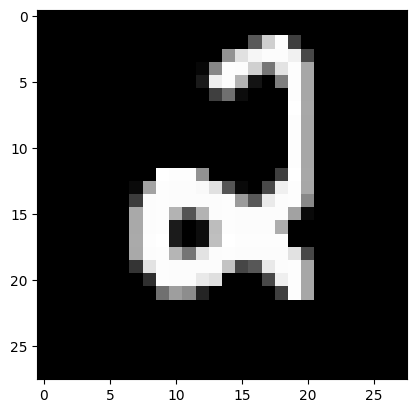

In [13]:
plt.imshow(images[1,0,:,:], cmap='gray')

### Training

In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
def evaluate(model, data_loader, device, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    model.train()
    return avg_loss, accuracy

In [16]:
# Train the model
model.train()
total_step = len(train_loader)
global_step = 0

for epoch in range(num_epochs):
    epoch_loss_sum = 0.0
    epoch_correct = 0
    epoch_total = 0

    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        global_step += 1
        epoch_loss_sum += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        epoch_correct += (predicted == labels).sum().item()
        epoch_total += labels.size(0)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            wandb.log({
                "train/batch_loss": loss.item(),
                "epoch": epoch + 1,
            }, step=global_step)

    train_loss = epoch_loss_sum / epoch_total
    train_acc = 100 * epoch_correct / epoch_total
    test_loss, test_acc = evaluate(model, test_loader, device, criterion)

    print(
        f"Epoch [{epoch + 1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%"
    )

    wandb.log({
        "train/loss": train_loss,
        "train/accuracy": train_acc,
        "test/loss": test_loss,
        "test/accuracy": test_acc,
        "lr": optimizer.param_groups[0]["lr"],
        "epoch": epoch + 1,
    }, step=global_step)

Epoch [1/5], Step [100/600], Loss: 0.2016
Epoch [1/5], Step [200/600], Loss: 0.3039
Epoch [1/5], Step [300/600], Loss: 0.0933
Epoch [1/5], Step [400/600], Loss: 0.1447
Epoch [1/5], Step [500/600], Loss: 0.1488
Epoch [1/5], Step [600/600], Loss: 0.1132
Epoch [1/5] Train Loss: 0.2535, Train Acc: 92.68% | Test Loss: 0.1080, Test Acc: 96.45%
Epoch [2/5], Step [100/600], Loss: 0.0866
Epoch [2/5], Step [200/600], Loss: 0.1046
Epoch [2/5], Step [300/600], Loss: 0.0865
Epoch [2/5], Step [400/600], Loss: 0.0557
Epoch [2/5], Step [500/600], Loss: 0.0280
Epoch [2/5], Step [600/600], Loss: 0.0293
Epoch [2/5] Train Loss: 0.0918, Train Acc: 97.05% | Test Loss: 0.0822, Test Acc: 97.53%
Epoch [3/5], Step [100/600], Loss: 0.0489
Epoch [3/5], Step [200/600], Loss: 0.0493
Epoch [3/5], Step [300/600], Loss: 0.0704
Epoch [3/5], Step [400/600], Loss: 0.0268
Epoch [3/5], Step [500/600], Loss: 0.0540
Epoch [3/5], Step [600/600], Loss: 0.0394
Epoch [3/5] Train Loss: 0.0604, Train Acc: 98.11% | Test Loss: 0.072

### Evaluation

We already log test loss and accuracy each epoch. The cell below re-runs evaluation to show the final metrics clearly.

In [17]:
final_test_loss, final_test_acc = evaluate(model, test_loader, device, criterion)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_acc:.2f}%")

wandb.log({
    "test/final_loss": final_test_loss,
    "test/final_accuracy": final_test_acc,
})

Final Test Loss: 0.0764, Final Test Accuracy: 97.83%


In [18]:
# Save the model checkpoint
# torch.save(model.state_dict(), 'models/model.ckpt')

In [19]:
# Close the W&B run
wandb.finish()

epoch,▁▁▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆██████
lr,▁▁▁▁▁
test/accuracy,▁▆▇█▇
test/final_accuracy,▁
test/final_loss,▁
test/loss,█▄▂▁▃
train/accuracy,▁▆▇██
train/batch_loss,▆█▃▄▄▄▃▃▃▂▂▂▂▂▃▂▂▂▁▂▂▃▁▃▁▁▂▂▁▂
train/loss,█▃▂▁▁
epoch,5
lr,0.001


### Explanation of the code

This notebook does the following:

- Loads the MNIST dataset with `torchvision` and wraps it in data loaders.
- Defines a simple two-hidden-layer feedforward network for digit classification.
- Trains with mini-batches and evaluates at the end of each epoch.
- Logs training and test loss/accuracy to W&B so you can monitor learning curves.

Tune hyperparameters such as the learning rate, hidden size, and batch size based on your dataset and performance goals.